In [0]:
#import libraries
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import losses, optimizers, metrics
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm_notebook

In [2]:
#download MNIST dataset
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  22.9M      0 --:--:-- --:--:-- --:--:-- 22.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  32212      0 --:--:-- --:--:-- --:--:-- 32212
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  5063k      0 --:--:-- --:--:-- --:--:-- 5047k


In [0]:
#unzip files
!gunzip t*-ubyte.gz

In [0]:
#load dataset
X_train, y_train = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

#reshape to image shape
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
#sampled training dataset
X_train_6k = X_train.copy()[:6000]/255.0
y_train_6k = y_train.copy()[:6000]
#augmented training dataset
X_train_12k = X_train.copy()[:12000]/255.0
y_train_12k = y_train.copy()[:12000]
#sampled test dataset
X_test = X_test[:1000]/255.0
y_test = y_test[:1000]

In [0]:
noise = 0.25 #25% noise

#pick random bernouli sample and assign fault label

bern = np.random.binomial(1,noise, len(y_train_6k))
s = sum(bern)
y_train_noise_6k = y_train_6k.copy()
y_train_noise_6k[bern==1] = np.random.randint(9,size=s)

bern = np.random.binomial(1,noise, len(y_train_12k))
s = sum(bern)
y_train_noise_12k = y_train_12k.copy()
y_train_noise_12k[bern==1] = np.random.randint(9,size=s)

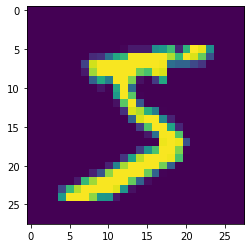

In [6]:
plt.imshow(X_train_6k[0].reshape(28,28))

In [7]:
y_train_6k[0]

5

In [0]:
#transform target output to one-hot-encoded representation
y_train_6k = tf.keras.utils.to_categorical(y_train_6k)
y_train_12k = tf.keras.utils.to_categorical(y_train_12k)
y_train_noise_6k = tf.keras.utils.to_categorical(y_train_noise_6k)
y_train_noise_12k = tf.keras.utils.to_categorical(y_train_noise_12k)

y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
y_train_6k[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
#blocks definition
#input_size = 32 #ONLY FOR CIFAR DATASET

input_size = 28
def cnn_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,pooling=2):
    '''function that returns a cnn block composed of Conv-BatchNorm-ReLU-MaxPool layers'''
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.MaxPool2D(pool_size=(pooling,pooling))(x)
    return x


def resnet_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,r=True): 
    '''function that returns a cnn block composed of two BatchNorm-ReLU-Convolution layers'''
    x = K.layers.BatchNormalization()(x_inp)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    if r:
        #interference Conv. layer in order to match the output dimensions
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x


def resnet(k=64):
    '''ResNet network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = resnet_block(images,k,strides=1)
    n_blocks = 4
    for i in range(1, n_blocks):
            x = resnet_block(x, k* (2**i),strides=2)   
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)


def cnn(k=64):
    '''CNN network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = cnn_block(images,k,pooling=1)
    n_blocks = 4
    for i in range(1, n_blocks):
        if i == 3:
            x = cnn_block(x, k* (2**i),pooling=4) 
            #x = cnn_block(x, k * (2**i),pooling=8) only for CIFAR DATASET   
        else:
            x = cnn_block(x, k * (2**i))
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)

In [0]:
net = cnn()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512   

In [0]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

In [0]:
net = resnet()
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 28, 28, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 28, 28, 1)    0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   640         activation_4[0][0]               
____________________________________________________________________________________________

In [0]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

## MODEL-WISE DOUBLE DESCENT

In [0]:
train_loss_noiseless = {}
test_loss_noiseless = {}
train_loss_noise = {}
test_loss_noise = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_noiseless = []
    error_test_noiseless = []
    error_train_noise = []
    error_test_noise = []
    s = '-'
    for _ in range(3):
        #noiseless
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noiseless.append(history.history['loss'][-1])
        error_test_noiseless.append(history.history['val_loss'][-1])
        #noise
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noise.append(history.history['loss'][-1])
        error_test_noise.append(history.history['val_loss'][-1])
    train_loss_noiseless[k] = np.mean(error_train_noiseless)
    test_loss_noiseless[k] = np.mean(error_test_noiseless)
    train_loss_noise[k] = np.mean(error_train_noise)
    test_loss_noise[k] = np.mean(error_test_noise)

    if k > 1:
        if list(test_loss_noiseless.values())[-1] >= list(test_loss_noiseless.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('NOISELESS: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noiseless[k],4),round(test_loss_noiseless[k],4),s))
    if k > 1:
        if list(test_loss_noise.values())[-1] >= list(test_loss_noise.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('25% NOISE: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noise[k],4),round(test_loss_noise[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


NOISELESS: k: 1, train_loss: 0.2183, test_loss: 0.3422 // -
25% NOISE: k: 1, train_loss: 1.2479, test_loss: 0.7111 // -


NOISELESS: k: 2, train_loss: 0.021, test_loss: 0.205 // -
25% NOISE: k: 2, train_loss: 0.9697, test_loss: 0.6068 // -


NOISELESS: k: 3, train_loss: 0.0019, test_loss: 0.1477 // -
25% NOISE: k: 3, train_loss: 0.6987, test_loss: 0.6775 // +


NOISELESS: k: 4, train_loss: 0.0006, test_loss: 0.1199 // -
25% NOISE: k: 4, train_loss: 0.3972, test_loss: 0.7988 // +


NOISELESS: k: 5, train_loss: 0.0004, test_loss: 0.1235 // +
25% NOISE: k: 5, train_loss: 0.1234, test_loss: 0.9693 // +


NOISELESS: k: 6, train_loss: 0.0003, test_loss: 0.1014 // -
25% NOISE: k: 6, train_loss: 0.032, test_loss: 0.9335 // -


NOISELESS: k: 7, train_loss: 0.0002, test_loss: 0.1061 // +
25% NOISE: k: 7, train_loss: 0.0088, test_loss: 0.8397 // -


NOISELESS: k: 8, train_loss: 0.0001, test_loss: 0.0964 // -
25% NOISE: k: 8, train_loss: 0.0038, test_loss: 0.7085 // -


NOISELESS: k: 9, train_loss

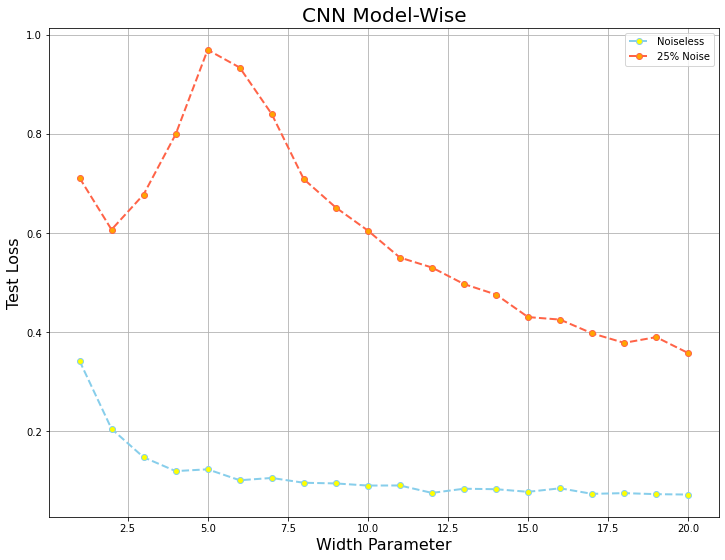

In [0]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='Noiseless')
plt.plot(list(test_loss_noise.keys()),list(test_loss_noise.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='25% Noise')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## SAMLE-WISE DOUBLE DESCENT

In [0]:
train_loss_6k = {}
test_loss_6k = {}
train_loss_12k = {}
test_loss_12k = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_6k = []
    error_test_6k = []
    error_train_12k = []
    error_test_12k = []
    s = '-'
    for _ in range(3):
        #6k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_6k.append(history.history['loss'][-1])
        error_test_6k.append(history.history['val_loss'][-1])
        #12k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_12k,y_train_noise_12k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_12k.append(history.history['loss'][-1])
        error_test_12k.append(history.history['val_loss'][-1])
    train_loss_6k[k] = np.mean(error_train_6k)
    test_loss_6k[k] = np.mean(error_test_6k)
    train_loss_12k[k] = np.mean(error_train_12k)
    test_loss_12k[k] = np.mean(error_test_12k)

    if k > 1:
        if list(test_loss_6k.values())[-1] >= list(test_loss_6k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('6k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_6k[k],4),round(test_loss_6k[k],4),s))
    if k > 1:
        if list(test_loss_12k.values())[-1] >= list(test_loss_12k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('12k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_12k[k],4),round(test_loss_12k[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


6k SAMPLES: k: 1, train_loss: 1.1909, test_loss: 0.6954 // -
12k SAMPLES: k: 1, train_loss: 1.2336, test_loss: 0.6522 // -


6k SAMPLES: k: 2, train_loss: 0.9735, test_loss: 0.6037 // -
12k SAMPLES: k: 2, train_loss: 1.0519, test_loss: 0.5006 // -


6k SAMPLES: k: 3, train_loss: 0.735, test_loss: 0.7096 // +
12k SAMPLES: k: 3, train_loss: 0.9162, test_loss: 0.5247 // +


6k SAMPLES: k: 4, train_loss: 0.3214, test_loss: 1.2316 // +
12k SAMPLES: k: 4, train_loss: 0.7196, test_loss: 0.6841 // +


6k SAMPLES: k: 5, train_loss: 0.15, test_loss: 1.6702 // +
12k SAMPLES: k: 5, train_loss: 0.515, test_loss: 0.9023 // +


6k SAMPLES: k: 6, train_loss: 0.0845, test_loss: 1.6459 // -
12k SAMPLES: k: 6, train_loss: 0.3006, test_loss: 1.1831 // +


6k SAMPLES: k: 7, train_loss: 0.0083, test_loss: 1.5057 // -
12k SAMPLES: k: 7, train_loss: 0.1703, test_loss: 1.5486 // +


6k SAMPLES: k: 8, train_loss: 0.0015, test_loss: 1.5599 // +
12k SAMPLES: k: 8, train_loss: 0.1381, test_loss: 1.4593 // -


6k S

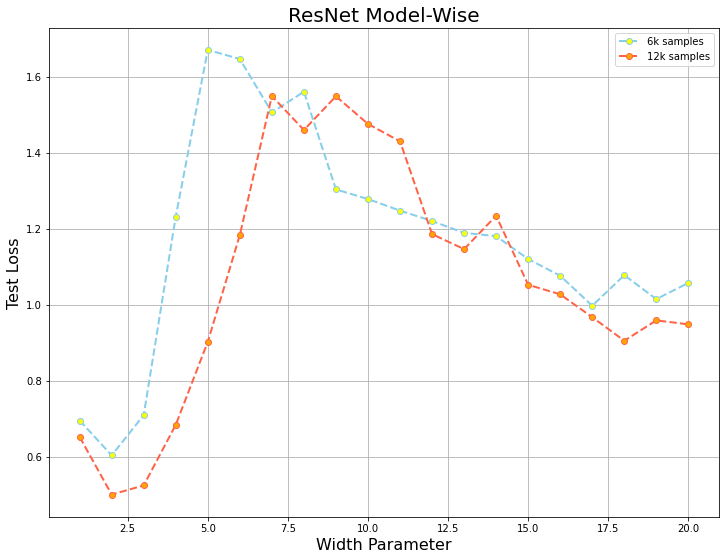

In [0]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_6k.keys()),list(test_loss_6k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='6k samples')
plt.plot(list(test_loss_12k.keys()),list(test_loss_12k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='12k samples')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## EPOCH-WISE DOUBLE DESCENT

### CNN

In [0]:
train_loss = {}
test_loss = {}
for k in [3,12,48]:
    print()
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,101,1)):
        error_train = []
        error_test = []
        s = '-'
        for _ in range(3):
            net = cnn(k)
            net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
            history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
            error_train.append(history.history['loss'][-1])
            error_test.append(history.history['val_loss'][-1])
        train_loss[k][e] = np.mean(error_train)
        test_loss[k][e] = np.mean(error_test)
        if e > 5:
            if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
                s = '+'
            else:
                s = '-'
        print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[k][e],4),round(test_loss[k][e],4),s))


Model width parameter k: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 5, train_loss: 1.4009, test_loss: 1.8172 // -
Epoch: 6, train_loss: 1.3184, test_loss: 1.2397 // -
Epoch: 7, train_loss: 1.2808, test_loss: 1.2917 // +
Epoch: 8, train_loss: 1.2769, test_loss: 1.0824 // -
Epoch: 9, train_loss: 1.2414, test_loss: 0.8935 // -
Epoch: 10, train_loss: 1.2289, test_loss: 0.8406 // -
Epoch: 11, train_loss: 1.1954, test_loss: 0.7016 // -
Epoch: 12, train_loss: 1.1834, test_loss: 0.7058 // +
Epoch: 13, train_loss: 1.178, test_loss: 0.6812 // -
Epoch: 14, train_loss: 1.162, test_loss: 0.7107 // +
Epoch: 15, train_loss: 1.1525, test_loss: 0.6649 // -
Epoch: 16, train_loss: 1.1572, test_loss: 0.6968 // +
Epoch: 17, train_loss: 1.1202, test_loss: 0.6264 // -
Epoch: 18, train_loss: 1.1455, test_loss: 0.6842 // +
Epoch: 19, train_loss: 1.112, test_loss: 0.6446 // -
Epoch: 20, train_loss: 1.1243, test_loss: 0.6343 // -
Epoch: 21, train_loss: 1.1161, test_loss: 0.6183 // -
Epoch: 22, train_loss: 1.0804, test_loss: 0.6438 // +
Epoch: 23, train_loss: 1.083, test_l

Epoch: 5, train_loss: 1.0477, test_loss: 2.5262 // -
Epoch: 6, train_loss: 0.9803, test_loss: 2.1265 // -
Epoch: 7, train_loss: 0.9494, test_loss: 1.6838 // -
Epoch: 8, train_loss: 0.8147, test_loss: 1.6702 // -
Epoch: 9, train_loss: 0.8268, test_loss: 1.2146 // -
Epoch: 10, train_loss: 0.7538, test_loss: 1.1132 // -
Epoch: 11, train_loss: 0.685, test_loss: 0.8684 // -
Epoch: 12, train_loss: 0.5605, test_loss: 0.9172 // +
Epoch: 13, train_loss: 0.5586, test_loss: 0.9911 // +
Epoch: 14, train_loss: 0.552, test_loss: 0.7731 // -
Epoch: 15, train_loss: 0.457, test_loss: 0.6895 // -
Epoch: 16, train_loss: 0.3381, test_loss: 0.6961 // +
Epoch: 17, train_loss: 0.3485, test_loss: 0.6426 // -
Epoch: 18, train_loss: 0.2828, test_loss: 0.6667 // +
Epoch: 19, train_loss: 0.2514, test_loss: 0.6175 // -
Epoch: 20, train_loss: 0.1897, test_loss: 0.6599 // +
Epoch: 21, train_loss: 0.1751, test_loss: 0.644 // -
Epoch: 22, train_loss: 0.1355, test_loss: 0.5759 // -
Epoch: 23, train_loss: 0.1422, test_l

Epoch: 5, train_loss: 0.989, test_loss: 3.8739 // -
Epoch: 6, train_loss: 0.9011, test_loss: 3.0187 // -
Epoch: 7, train_loss: 0.7894, test_loss: 3.5915 // +
Epoch: 8, train_loss: 0.7134, test_loss: 3.24 // -
Epoch: 9, train_loss: 0.5692, test_loss: 3.3355 // +
Epoch: 10, train_loss: 0.4777, test_loss: 1.76 // -
Epoch: 11, train_loss: 0.2798, test_loss: 1.9762 // +
Epoch: 12, train_loss: 0.1048, test_loss: 1.353 // -
Epoch: 13, train_loss: 0.102, test_loss: 1.1937 // -
Epoch: 14, train_loss: 0.0407, test_loss: 0.9313 // -
Epoch: 15, train_loss: 0.0225, test_loss: 0.5751 // -
Epoch: 16, train_loss: 0.0066, test_loss: 0.454 // -
Epoch: 17, train_loss: 0.0056, test_loss: 0.3833 // -
Epoch: 18, train_loss: 0.0051, test_loss: 0.3332 // -
Epoch: 19, train_loss: 0.0033, test_loss: 0.3234 // -
Epoch: 20, train_loss: 0.0029, test_loss: 0.3096 // -
Epoch: 21, train_loss: 0.0026, test_loss: 0.297 // -
Epoch: 22, train_loss: 0.0021, test_loss: 0.2959 // -
Epoch: 23, train_loss: 0.0022, test_loss: 

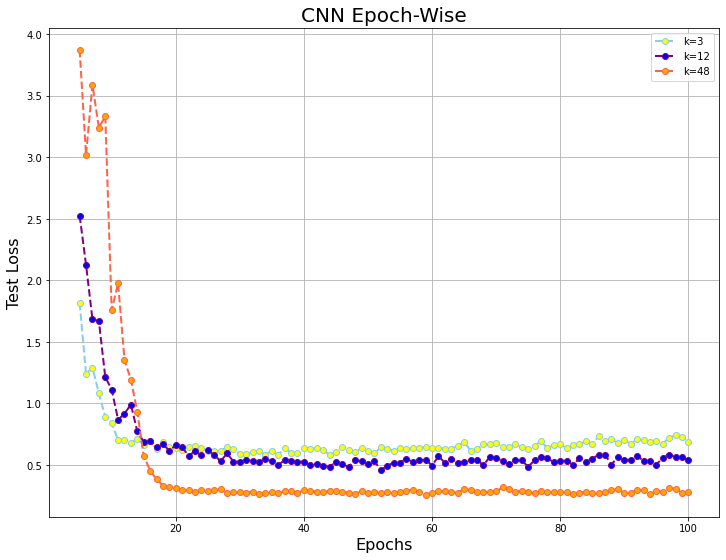

In [0]:
#multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss[3].keys()),list(test_loss[3].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='k=3')
plt.plot(list(test_loss[12].keys()),list(test_loss[12].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='blue', color='purple', linewidth=2,markersize=12,label='k=12')
plt.plot(list(test_loss[48].keys()),list(test_loss[48].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

### ResNet

In [11]:
train_loss = {}
test_loss = {}
for k in [3,12,48]:
    print()
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,101,1)):
        error_train = []
        error_test = []
        s = '-'
        for _ in range(3):
            net = resnet(k)
            net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
            history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
            error_train.append(history.history['loss'][-1])
            error_test.append(history.history['val_loss'][-1])
        train_loss[k][e] = np.mean(error_train)
        test_loss[k][e] = np.mean(error_test)
        if e > 5:
            if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
                s = '+'
            else:
                s = '-'
        print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[k][e],4),round(test_loss[k][e],4),s))


Model width parameter k: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 5, train_loss: 1.3091, test_loss: 1.4248 // -
Epoch: 6, train_loss: 1.2631, test_loss: 1.0099 // -
Epoch: 7, train_loss: 1.1993, test_loss: 0.9096 // -
Epoch: 8, train_loss: 1.1872, test_loss: 0.8674 // -
Epoch: 9, train_loss: 1.1722, test_loss: 0.7831 // -
Epoch: 10, train_loss: 1.1636, test_loss: 0.7019 // -
Epoch: 11, train_loss: 1.1371, test_loss: 0.6908 // -
Epoch: 12, train_loss: 1.1197, test_loss: 0.658 // -
Epoch: 13, train_loss: 1.1125, test_loss: 0.6547 // -
Epoch: 14, train_loss: 1.0921, test_loss: 0.5883 // -
Epoch: 15, train_loss: 1.0726, test_loss: 0.6029 // +
Epoch: 16, train_loss: 1.0602, test_loss: 0.6012 // -
Epoch: 17, train_loss: 1.0462, test_loss: 0.615 // +
Epoch: 18, train_loss: 1.0549, test_loss: 0.6247 // +
Epoch: 19, train_loss: 1.0349, test_loss: 0.5998 // -
Epoch: 20, train_loss: 1.0301, test_loss: 0.5991 // -
Epoch: 21, train_loss: 1.0031, test_loss: 0.6342 // +
Epoch: 22, train_loss: 1.0032, test_loss: 0.6049 // -
Epoch: 23, train_loss: 0.9907, test

Epoch: 5, train_loss: 0.8719, test_loss: 1.6419 // -
Epoch: 6, train_loss: 0.7773, test_loss: 1.3107 // -
Epoch: 7, train_loss: 0.6562, test_loss: 0.9981 // -
Epoch: 8, train_loss: 0.5298, test_loss: 1.0522 // +
Epoch: 9, train_loss: 0.4314, test_loss: 0.9563 // -
Epoch: 10, train_loss: 0.3586, test_loss: 0.9038 // -
Epoch: 11, train_loss: 0.2351, test_loss: 1.021 // +
Epoch: 12, train_loss: 0.208, test_loss: 1.0364 // +
Epoch: 13, train_loss: 0.1734, test_loss: 1.0075 // -
Epoch: 14, train_loss: 0.1332, test_loss: 1.085 // +
Epoch: 15, train_loss: 0.1252, test_loss: 1.1145 // +
Epoch: 16, train_loss: 0.0872, test_loss: 1.1737 // +
Epoch: 17, train_loss: 0.0807, test_loss: 1.1601 // -
Epoch: 18, train_loss: 0.0813, test_loss: 1.2609 // +
Epoch: 19, train_loss: 0.1166, test_loss: 1.1926 // -
Epoch: 20, train_loss: 0.102, test_loss: 1.412 // +
Epoch: 21, train_loss: 0.1027, test_loss: 1.4116 // -
Epoch: 22, train_loss: 0.0999, test_loss: 1.3284 // -
Epoch: 23, train_loss: 0.0972, test_lo

Epoch: 5, train_loss: 0.8032, test_loss: 2.2161 // -
Epoch: 6, train_loss: 0.6598, test_loss: 1.6302 // -
Epoch: 7, train_loss: 0.4665, test_loss: 1.1643 // -
Epoch: 8, train_loss: 0.3257, test_loss: 1.0377 // -
Epoch: 9, train_loss: 0.2327, test_loss: 1.3734 // +
Epoch: 10, train_loss: 0.1929, test_loss: 0.9158 // -
Epoch: 11, train_loss: 0.1858, test_loss: 1.0798 // +
Epoch: 12, train_loss: 0.16, test_loss: 1.2029 // +
Epoch: 13, train_loss: 0.1216, test_loss: 1.2335 // +
Epoch: 14, train_loss: 0.1274, test_loss: 1.2078 // -
Epoch: 15, train_loss: 0.1146, test_loss: 1.2356 // +
Epoch: 16, train_loss: 0.1071, test_loss: 1.1094 // -
Epoch: 17, train_loss: 0.0928, test_loss: 1.3955 // +
Epoch: 18, train_loss: 0.0717, test_loss: 1.3584 // -
Epoch: 19, train_loss: 0.1141, test_loss: 1.4896 // +
Epoch: 20, train_loss: 0.0836, test_loss: 1.3348 // -
Epoch: 21, train_loss: 0.0657, test_loss: 1.4229 // +
Epoch: 22, train_loss: 0.0754, test_loss: 1.3539 // -
Epoch: 23, train_loss: 0.0716, test

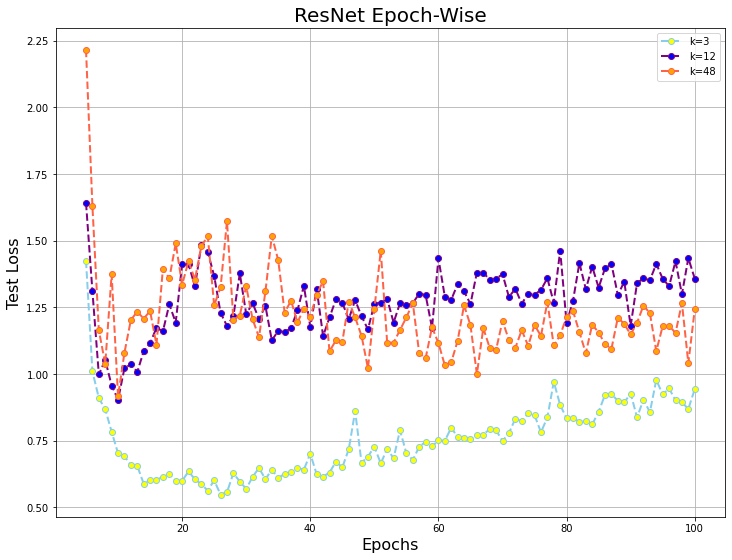

In [12]:
#multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss[3].keys()),list(test_loss[3].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='k=3')
plt.plot(list(test_loss[12].keys()),list(test_loss[12].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='blue', color='purple', linewidth=2,markersize=12,label='k=12')
plt.plot(list(test_loss[48].keys()),list(test_loss[48].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()